# Method 6 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

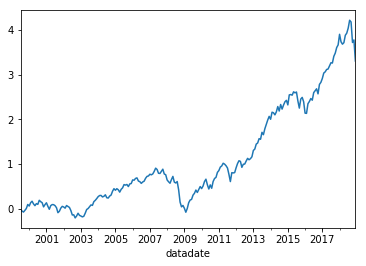

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.099416
2000-12-31   -0.003055
2001-12-31   -0.035264
2002-12-31   -0.190485
2003-12-31    0.438318
2004-12-31    0.179469
2005-12-31    0.079226
2006-12-31    0.108190
2007-12-31    0.015944
2008-12-31   -0.389126
2009-12-31    0.391729
2010-12-31    0.211158
2011-12-31   -0.003203
2012-12-31    0.195064
2013-12-31    0.417204
2014-12-31    0.116850
2015-12-31   -0.009401
2016-12-31    0.127908
2017-12-31    0.218567
2018-12-31   -0.077147
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2679.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.84e-191
Time:                        14:57:12   Log-Likelihood:                 842.44
No. Observations:                 234   AIC:                            -1675.
Df Residuals:                     229   BIC:                            -1658.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.860      0.000       0.001       0.003
mktrf          0.9851      0.012     79.044      0.000       0.961       1.010
me             0.2445      0.014     16.869      0.000       0.216       0.273
ia             0.0777      0.022      3.525      0.001       0.034       0.121
roe            0.0153      0.019      0.811      0.418      -0.022       0.052
==============================================================================
Omnibus:                       16.339   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.674
Skew:                          -0.110   Prob(JB):                     4.44e-11
Kurtosis:                       5.200   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1632.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.62e-167
Time:                        14:57:12   Log-Likelihood:                 842.44
No. Observations:                 234   AIC:                            -1675.
Df Residuals:                     229   BIC:                            -1658.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.701      0.000       0.001       0.003
mktrf          0.9851      0.016     59.870      0.000       0.953       1.017
me             0.2445      0.030      8.179      0.000       0.186       0.303
ia             0.0777      0.044      1.752      0.080      -0.009       0.165
roe            0.0153      0.023      0.660      0.509      -0.030       0.061
==============================================================================
Omnibus:                       16.339   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.674
Skew:                          -0.110   Prob(JB):                     4.44e-11
Kurtosis:                       5.200   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2151.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-180
Time:                        14:57:12   Log-Likelihood:                 842.44
No. Observations:                 234   AIC:                            -1675.
Df Residuals:                     229   BIC:                            -1658.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.041      0.000       0.001       0.003
mktrf          0.9851      0.015     63.818      0.000       0.955       1.015
me             0.2445      0.028      8.628      0.000       0.189       0.300
ia             0.0777      0.049      1.571      0.116      -0.019       0.175
roe            0.0153      0.025      0.601      0.548      -0.035       0.065
==============================================================================
Omnibus:                       16.339   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.674
Skew:                          -0.110   Prob(JB):                     4.44e-11
Kurtosis:                       5.200   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1904.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.04e-183
Time:                        14:57:12   Log-Likelihood:                 829.42
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.879      0.000       0.001       0.003
mktrf          0.9967      0.013     75.333      0.000       0.971       1.023
smb            0.2770      0.017     15.870      0.000       0.243       0.311
hml            0.0162      0.021      0.786      0.433      -0.024       0.057
rmw            0.0489      0.023      2.102      0.037       0.003       0.095
cma            0.0542      0.030      1.831      0.068      -0.004       0.112
==============================================================================
Omnibus:                       22.184   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.509
Skew:                          -0.024   Prob(JB):                     8.17e-21
Kurtosis:                       6.080   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1177.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.26e-160
Time:                        14:57:12   Log-Likelihood:                 829.42
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.614      0.000       0.001       0.003
mktrf          0.9967      0.020     50.388      0.000       0.958       1.035
smb            0.2770      0.025     11.140      0.000       0.228       0.326
hml            0.0162      0.048      0.337      0.736      -0.078       0.110
rmw            0.0489      0.027      1.835      0.066      -0.003       0.101
cma            0.0542      0.047      1.144      0.252      -0.039       0.147
==============================================================================
Omnibus:                       22.184   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.509
Skew:                          -0.024   Prob(JB):                     8.17e-21
Kurtosis:                       6.080   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1614.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.88e-176
Time:                        14:57:12   Log-Likelihood:                 829.42
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.661      0.000       0.001       0.003
mktrf          0.9967      0.019     51.722      0.000       0.959       1.034
smb            0.2770      0.025     11.290      0.000       0.229       0.325
hml            0.0162      0.052      0.309      0.757      -0.086       0.119
rmw            0.0489      0.030      1.657      0.098      -0.009       0.107
cma            0.0542      0.046      1.190      0.234      -0.035       0.143
==============================================================================
Omnibus:                       22.184   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.509
Skew:                          -0.024   Prob(JB):                     8.17e-21
Kurtosis:                       6.080   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2088.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.38e-179
Time:                        14:57:12   Log-Likelihood:                 813.96
No. Observations:                 234   AIC:                            -1618.
Df Residuals:                     229   BIC:                            -1601.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.641      0.000       0.001       0.003
mktrf          0.9805      0.013     75.660      0.000       0.955       1.006
smb            0.2422      0.016     14.971      0.000       0.210       0.274
hml            0.1048      0.016      6.523      0.000       0.073       0.136
umd            0.0023      0.011      0.223      0.824      -0.018       0.023
==============================================================================
Omnibus:                       23.725   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.775
Skew:                           0.033   Prob(JB):                     6.52e-24
Kurtosis:                       6.309   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1586.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.32e-165
Time:                        14:57:12   Log-Likelihood:                 813.96
No. Observations:                 234   AIC:                            -1618.
Df Residuals:                     229   BIC:                            -1601.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.830      0.000       0.001       0.004
mktrf          0.9805      0.019     52.440      0.000       0.944       1.017
smb            0.2422      0.029      8.348      0.000       0.185       0.299
hml            0.1048      0.050      2.086      0.037       0.006       0.203
umd            0.0023      0.018      0.132      0.895      -0.032       0.037
==============================================================================
Omnibus:                       23.725   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.775
Skew:                           0.033   Prob(JB):                     6.52e-24
Kurtosis:                       6.309   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2099.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.07e-179
Time:                        14:57:12   Log-Likelihood:                 813.96
No. Observations:                 234   AIC:                            -1618.
Df Residuals:                     229   BIC:                            -1601.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.857      0.000       0.001       0.004
mktrf          0.9805      0.017     58.890      0.000       0.948       1.013
smb            0.2422      0.031      7.938      0.000       0.182       0.302
hml            0.1048      0.058      1.810      0.070      -0.009       0.218
umd            0.0023      0.014      0.169      0.866      -0.025       0.030
==============================================================================
Omnibus:                       23.725   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.775
Skew:                           0.033   Prob(JB):                     6.52e-24
Kurtosis:                       6.309   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1212.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.53e-93
Time:                        14:57:12   Log-Likelihood:                 414.60
No. Observations:                 120   AIC:                            -819.2
Df Residuals:                     115   BIC:                            -805.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.447      0.001       0.001       0.004
mktrf          0.9956      0.020     49.471      0.000       0.956       1.035
me             0.2294      0.020     11.540      0.000       0.190       0.269
ia             0.1247      0.031      4.006      0.000       0.063       0.186
roe            0.0204      0.028      0.741      0.460      -0.034       0.075
==============================================================================
Omnibus:                        6.381   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.512
Skew:                          -0.078   Prob(JB):                      0.00522
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     918.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-86
Time:                        14:57:12   Log-Likelihood:                 414.60
No. Observations:                 120   AIC:                            -819.2
Df Residuals:                     115   BIC:                            -805.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.178      0.001       0.001       0.004
mktrf          0.9956      0.026     38.278      0.000       0.945       1.047
me             0.2294      0.030      7.527      0.000       0.170       0.289
ia             0.1247      0.045      2.767      0.006       0.036       0.213
roe            0.0204      0.026      0.795      0.427      -0.030       0.071
==============================================================================
Omnibus:                        6.381   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.512
Skew:                          -0.078   Prob(JB):                      0.00522
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1591.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-99
Time:                        14:57:12   Log-Likelihood:                 414.60
No. Observations:                 120   AIC:                            -819.2
Df Residuals:                     115   BIC:                            -805.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.311      0.001       0.001       0.004
mktrf          0.9956      0.022     45.874      0.000       0.953       1.038
me             0.2294      0.030      7.748      0.000       0.171       0.287
ia             0.1247      0.044      2.804      0.005       0.038       0.212
roe            0.0204      0.025      0.805      0.421      -0.029       0.070
==============================================================================
Omnibus:                        6.381   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.041   Jarque-Bera (JB):               10.512
Skew:                          -0.078   Prob(JB):                      0.00522
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     822.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.20e-87
Time:                        14:57:12   Log-Likelihood:                 405.46
No. Observations:                 120   AIC:                            -798.9
Df Residuals:                     114   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.167      0.002       0.001       0.004
mktrf          1.0344      0.023     44.976      0.000       0.989       1.080
smb            0.2802      0.026     10.757      0.000       0.229       0.332
hml            0.0002      0.032      0.005      0.996      -0.063       0.063
rmw            0.0836      0.038      2.221      0.028       0.009       0.158
cma            0.1165      0.041      2.826      0.006       0.035       0.198
==============================================================================
Omnibus:                       11.378   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.178
Skew:                          -0.053   Prob(JB):                     1.70e-07
Kurtosis:                       5.495   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     768.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.10e-86
Time:                        14:57:12   Log-Likelihood:                 405.46
No. Observations:                 120   AIC:                            -798.9
Df Residuals:                     114   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.968      0.003       0.001       0.004
mktrf          1.0344      0.036     28.429      0.000       0.963       1.106
smb            0.2802      0.036      7.746      0.000       0.209       0.351
hml            0.0002      0.080      0.002      0.998      -0.157       0.157
rmw            0.0836      0.057      1.476      0.140      -0.027       0.195
cma            0.1165      0.062      1.895      0.058      -0.004       0.237
==============================================================================
Omnibus:                       11.378   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.178
Skew:                          -0.053   Prob(JB):                     1.70e-07
Kurtosis:                       5.495   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1364.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.59e-100
Time:                        14:57:12   Log-Likelihood:                 405.46
No. Observations:                 120   AIC:                            -798.9
Df Residuals:                     114   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.240      0.001       0.001       0.004
mktrf          1.0344      0.035     29.865      0.000       0.967       1.102
smb            0.2802      0.036      7.791      0.000       0.210       0.351
hml            0.0002      0.088      0.002      0.998      -0.172       0.173
rmw            0.0836      0.061      1.360      0.174      -0.037       0.204
cma            0.1165      0.061      1.906      0.057      -0.003       0.236
==============================================================================
Omnibus:                       11.378   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.178
Skew:                          -0.053   Prob(JB):                     1.70e-07
Kurtosis:                       5.495   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     864.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.06e-85
Time:                        14:57:12   Log-Likelihood:                 394.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     115   BIC:                            -765.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.006      0.000       0.002       0.005
mktrf          0.9892      0.021     47.330      0.000       0.948       1.031
smb            0.2376      0.024      9.983      0.000       0.190       0.285
hml            0.1369      0.024      5.742      0.000       0.090       0.184
umd            0.0022      0.015      0.147      0.883      -0.027       0.031
==============================================================================
Omnibus:                       13.151   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.010
Skew:                          -0.051   Prob(JB):                     7.54e-10
Kurtosis:                       5.897   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1153.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.23e-92
Time:                        14:57:12   Log-Likelihood:                 394.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     115   BIC:                            -765.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.896      0.000       0.002       0.005
mktrf          0.9892      0.030     32.971      0.000       0.930       1.048
smb            0.2376      0.033      7.162      0.000       0.173       0.303
hml            0.1369      0.063      2.188      0.029       0.014       0.259
umd            0.0022      0.021      0.103      0.918      -0.039       0.043
==============================================================================
Omnibus:                       13.151   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.010
Skew:                          -0.051   Prob(JB):                     7.54e-10
Kurtosis:                       5.897   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2115.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.23e-106
Time:                        14:57:12   Log-Likelihood:                 394.85
No. Observations:                 120   AIC:                            -779.7
Df Residuals:                     115   BIC:                            -765.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.217      0.000       0.002       0.005
mktrf          0.9892      0.024     41.349      0.000       0.942       1.036
smb            0.2376      0.036      6.692      0.000       0.168       0.307
hml            0.1369      0.069      1.980      0.048       0.001       0.272
umd            0.0022      0.017      0.131      0.896      -0.030       0.035
==============================================================================
Omnibus:                       13.151   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.010
Skew:                          -0.051   Prob(JB):                     7.54e-10
Kurtosis:                       5.897   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2260.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.58e-104
Time:                        14:57:12   Log-Likelihood:                 458.05
No. Observations:                 114   AIC:                            -906.1
Df Residuals:                     109   BIC:                            -892.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.631      0.000       0.001       0.003
mktrf          0.9742      0.013     74.436      0.000       0.948       1.000
me             0.2829      0.020     14.002      0.000       0.243       0.323
ia            -0.0739      0.028     -2.637      0.010      -0.129      -0.018
roe           -0.0479      0.025     -1.943      0.055      -0.097       0.001
==============================================================================
Omnibus:                        4.894   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.295
Skew:                          -0.408   Prob(JB):                        0.117
Kurtosis:                       3.489   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3941.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.96e-117
Time:                        14:57:12   Log-Likelihood:                 458.05
No. Observations:                 114   AIC:                            -906.1
Df Residuals:                     109   BIC:                            -892.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.351      0.000       0.001       0.003
mktrf          0.9742      0.010     99.406      0.000       0.955       0.993
me             0.2829      0.021     13.780      0.000       0.243       0.323
ia            -0.0739      0.030     -2.444      0.015      -0.133      -0.015
roe           -0.0479      0.025     -1.939      0.052      -0.096       0.001
==============================================================================
Omnibus:                        4.894   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.295
Skew:                          -0.408   Prob(JB):                        0.117
Kurtosis:                       3.489   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5124.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.67e-123
Time:                        14:57:12   Log-Likelihood:                 458.05
No. Observations:                 114   AIC:                            -906.1
Df Residuals:                     109   BIC:                            -892.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.913      0.000       0.001       0.003
mktrf          0.9742      0.009    109.162      0.000       0.957       0.992
me             0.2829      0.022     12.833      0.000       0.240       0.326
ia            -0.0739      0.034     -2.204      0.027      -0.140      -0.008
roe           -0.0479      0.022     -2.177      0.029      -0.091      -0.005
==============================================================================
Omnibus:                        4.894   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.295
Skew:                          -0.408   Prob(JB):                        0.117
Kurtosis:                       3.489   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2650.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.16e-111
Time:                        14:57:12   Log-Likelihood:                 480.14
No. Observations:                 114   AIC:                            -948.3
Df Residuals:                     108   BIC:                            -931.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.336      0.001       0.000       0.002
mktrf          0.9783      0.010     94.704      0.000       0.958       0.999
smb            0.2619      0.017     15.615      0.000       0.229       0.295
hml           -0.0184      0.021     -0.860      0.392      -0.061       0.024
rmw           -0.1097      0.026     -4.188      0.000      -0.162      -0.058
cma           -0.0762      0.033     -2.291      0.024      -0.142      -0.010
==============================================================================
Omnibus:                        6.345   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.833
Skew:                          -0.483   Prob(JB):                       0.0541
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3177.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-115
Time:                        14:57:12   Log-Likelihood:                 480.14
No. Observations:                 114   AIC:                            -948.3
Df Residuals:                     108   BIC:                            -931.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.106      0.002       0.000       0.002
mktrf          0.9783      0.009    108.239      0.000       0.961       0.996
smb            0.2619      0.018     14.604      0.000       0.227       0.297
hml           -0.0184      0.019     -0.964      0.335      -0.056       0.019
rmw           -0.1097      0.022     -5.057      0.000      -0.152      -0.067
cma           -0.0762      0.036     -2.089      0.037      -0.148      -0.005
==============================================================================
Omnibus:                        6.345   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.833
Skew:                          -0.483   Prob(JB):                       0.0541
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5579.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-128
Time:                        14:57:12   Log-Likelihood:                 480.14
No. Observations:                 114   AIC:                            -948.3
Df Residuals:                     108   BIC:                            -931.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.718      0.007       0.000       0.002
mktrf          0.9783      0.008    129.374      0.000       0.964       0.993
smb            0.2619      0.017     15.574      0.000       0.229       0.295
hml           -0.0184      0.017     -1.065      0.287      -0.052       0.015
rmw           -0.1097      0.024     -4.499      0.000      -0.157      -0.062
cma           -0.0762      0.036     -2.091      0.037      -0.148      -0.005
==============================================================================
Omnibus:                        6.345   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.833
Skew:                          -0.483   Prob(JB):                       0.0541
Kurtosis:                       3.545   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.89e-107
Time:                        14:57:12   Log-Likelihood:                 466.29
No. Observations:                 114   AIC:                            -922.6
Df Residuals:                     109   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.213      0.029     9.5e-05       0.002
mktrf          0.9889      0.012     85.708      0.000       0.966       1.012
smb            0.2861      0.018     15.905      0.000       0.250       0.322
hml           -0.0160      0.019     -0.866      0.389      -0.053       0.021
umd           -0.0098      0.014     -0.699      0.486      -0.037       0.018
==============================================================================
Omnibus:                        6.471   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.026
Skew:                          -0.473   Prob(JB):                       0.0491
Kurtosis:                       3.611   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1880.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-99
Time:                        14:57:12   Log-Likelihood:                 466.29
No. Observations:                 114   AIC:                            -922.6
Df Residuals:                     109   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.958      0.050   -7.78e-07       0.002
mktrf          0.9889      0.012     80.073      0.000       0.965       1.013
smb            0.2861      0.018     16.191      0.000       0.251       0.321
hml           -0.0160      0.015     -1.066      0.286      -0.046       0.013
umd           -0.0098      0.008     -1.227      0.220      -0.025       0.006
==============================================================================
Omnibus:                        6.471   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.026
Skew:                          -0.473   Prob(JB):                       0.0491
Kurtosis:                       3.611   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2394.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.44e-105
Time:                        14:57:12   Log-Likelihood:                 466.29
No. Observations:                 114   AIC:                            -922.6
Df Residuals:                     109   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.836      0.066   -6.17e-05       0.002
mktrf          0.9889      0.012     85.273      0.000       0.966       1.012
smb            0.2861      0.014     19.809      0.000       0.258       0.314
hml           -0.0160      0.013     -1.200      0.230      -0.042       0.010
umd           -0.0098      0.008     -1.262      0.207      -0.025       0.005
==============================================================================
Omnibus:                        6.471   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.026
Skew:                          -0.473   Prob(JB):                       0.0491
Kurtosis:                       3.611   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""